In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plot1qbit
import glob

In [31]:
def plot_grid(data, N=None, M=None, label=None):
    if N is None or M is None:
        N=2
        M=5
    s = 1.
    fig, axs = plt.subplots(N,M,figsize=(M*s,N*s))
    for i in range(N):
        for j in range(M):
            try:
                axs[i,j].imshow(data[i*M+j])
            except IndexError:
                pass
            axs[i,j].set_axis_off()
    plt.tight_layout()
    if label:
        fig.suptitle(label)
    fig.show()

    
def plt_samples(iter_, template):
    try:
        d = np.load(template.replace("{i}", str(iter_)))
        plot_grid(d, label=f"Step {iter_}")
    except FileNotFoundError as e:
        #print(e)
        pass
        
def plt_general(var, template, label_template="", npz_file=None, n=None, m=None):
    try:
        d = np.load(template.format(var))
        if npz_file is not None:
            print([i for i in d.keys()])
            d = d[npz_file]
        plot_grid(d, label=label_template.format(var), N=n, M=m)
    except FileNotFoundError:
        pass
        

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


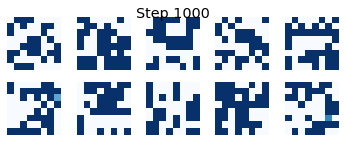

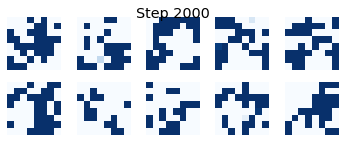

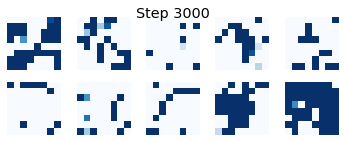

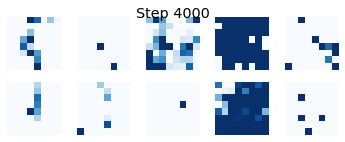

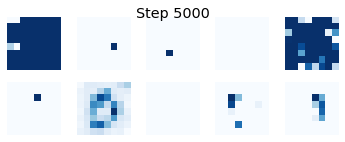

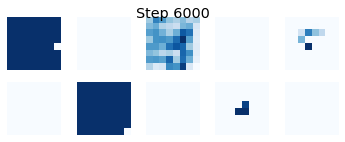

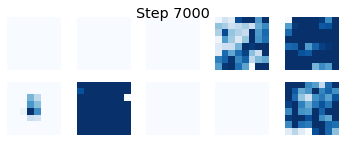

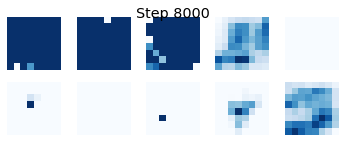

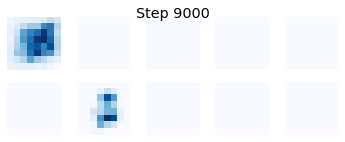

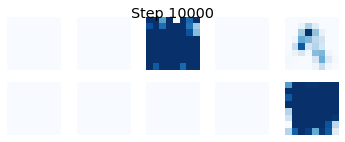

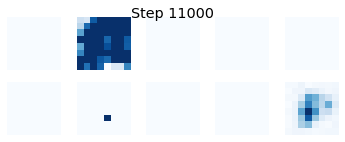

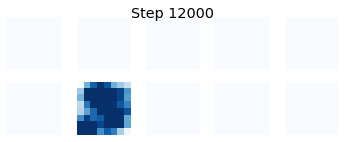

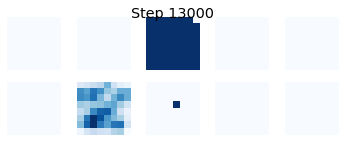

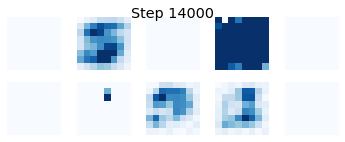

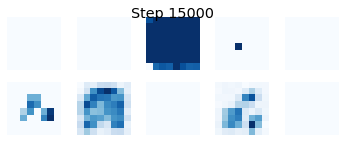

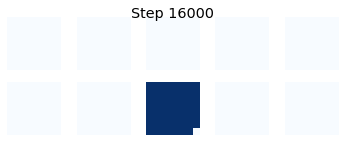

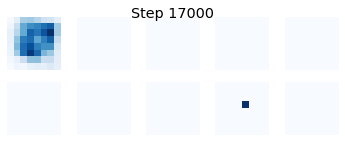

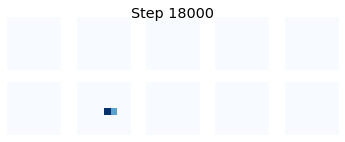

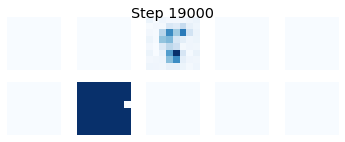

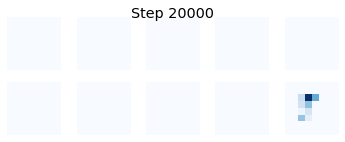

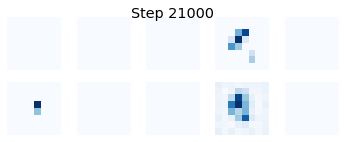

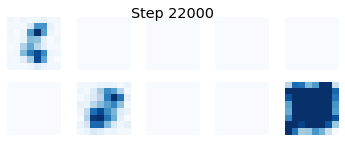

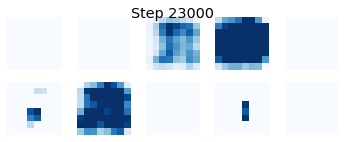

In [42]:
sample_dirs = sorted(glob.glob("./workdir_SSM_radermacher/samples/iter_*"), key=lambda x: int(x.split("_")[-1]))

for _d in sample_dirs:
    plt_samples(iter_=_d.split("_")[-1], template=f"{_d}/sample.np")

['samples']


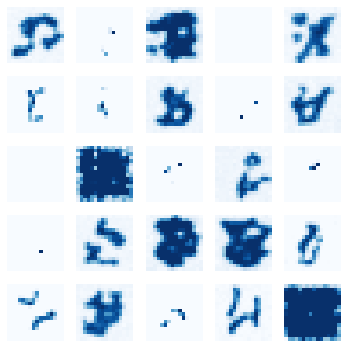

In [34]:
plt_general(var=108, template="./workdir_SSM_radermacher/evaled/ckpt_{}/samples_0.npz", npz_file="samples", n=5,m=5)

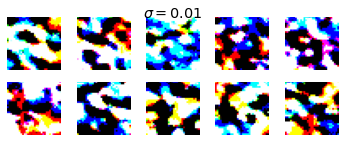

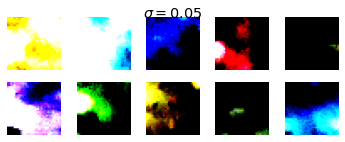

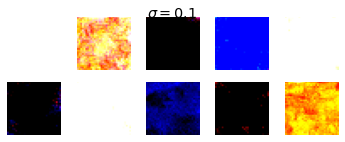

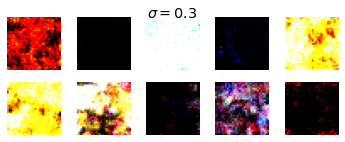

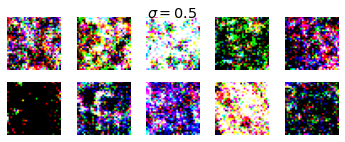

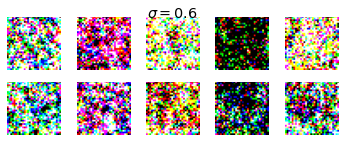

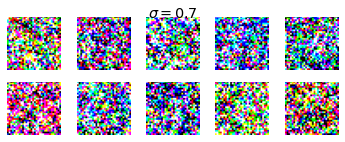

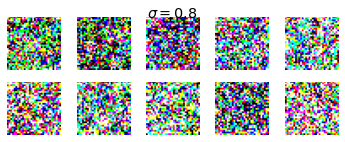

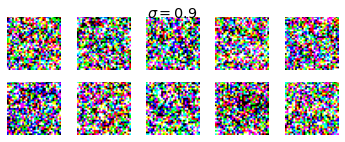

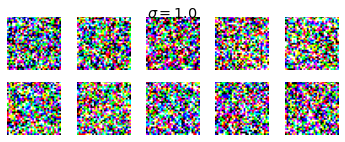

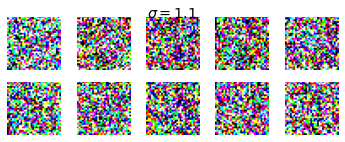

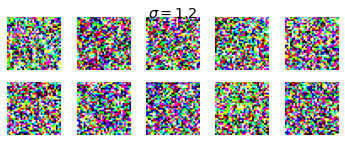

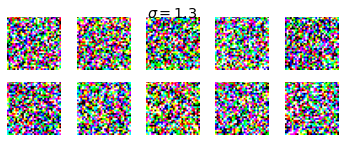

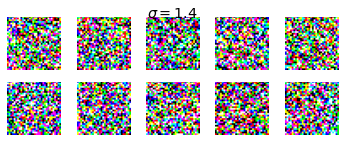

In [197]:
for sigma in [0.01, 0.05] + list(np.arange(0.1,1.5,0.1)):
    sigma = round(sigma,2)
    plt_general(var=sigma, template="./workdir_{}/samples/iter_4000/sample.np", label_template="$\sigma=${}")